In [1]:
%%capture

from ding0.core import NetworkDing0
from ding0.tools.logger import setup_logger
from ding0.tools.results import save_nd_to_pickle
from ding0.tools.plots import plot_mv_topology
from egoio.tools import db
from sqlalchemy.orm import sessionmaker
import oedialect

# create new network
nd = NetworkDing0(name='network')



# set ID of MV grid district
mv_grid_districts = [40] # fn

In [2]:
engine = db.connection(section='oedb_dialect', readonly=True)
session = sessionmaker(bind=engine)()

In [3]:
# due to load_nd_from_pickle
from ding0.tools import results

In [4]:
load_from_pkl=True

if load_from_pkl:
    
    print('LOAD DING0 GRID FROM PKL')

    grid_id=40
    nd = results.load_nd_from_pickle(filename='./config/tmp/ding0_grids__' + str(grid_id) + '.pkl')
    
    # should be closed before export
    nd.control_circuit_breakers(mode='open')


else:
    
    print('DING0.RUN()')
    
    nd.import_mv_grid_districts(session, mv_grid_districts_no=mv_grid_districts)
    nd.import_generators(session)

    nd.mv_parametrize_grid()
    nd.validate_grid_districts()
    
    build_lv_grid_default=True

    if build_lv_grid_default:

        nd.build_lv_grids()

    else:

        print('IMPLEMENT_MY_ROUTING')
        
        
    nd.mv_routing()
    
    nd.connect_generators()
    #nd.set_branch_ids()
    nd.set_circuit_breakers()
    
    
    nd.control_circuit_breakers(mode='open')
    nd.run_powerflow(session)
    
    nd.reinforce_grid()
    
    
    
    #nd.control_circuit_breakers(mode='close')
    #save_nd_to_pickle(nd, filename='ding0_grids__40.pkl')

LOAD DING0 GRID FROM PKL


In [5]:
import networkx as nx # to enable nx.draw()
import pandas as pd
from sqlalchemy import func
from geoalchemy2.shape import to_shape 
from shapely.wkt import loads

In [6]:
from config.config_lv_grids_osm import get_config_osm 
from config.db_conn_local_bw_sandbox import get_session_osm
from config.classes_db_conn.osm_load_classes import Buildings_with_Amenities, Building_wo_Amenity, Amenities_ni_Buildings, Way

In [7]:
from grid.lv_grid.routing import build_graph_from_ways, nearest_nodes
from grid.lv_grid.parameterization import parameterize_by_load_profiles
from grid.lv_grid.clustering import get_n_cluster, cluster_k_means

In [8]:
from grid.lv_grid.geo import get_points_in_load_area, get_convex_hull_from_points

In [9]:
session_osm = get_session_osm()

In [10]:
# FOR TESTING REASONS SELECT ONE LOAD_AREA (Fallenbrunnen) BY ID
id_load_area_fallenbrunnen = '4544'

load_areas = []


for mv_grid_district in nd.mv_grid_districts():
    for load_area in mv_grid_district.lv_load_areas():
        
        
        if not load_area.is_aggregated:
                
            if id_load_area_fallenbrunnen in str(load_area):
                
                fn_fallenbrunnen_la  = load_area
                fn_fallenbrunnen_geo = fn_fallenbrunnen_la.geo_area
                
                #for lv_district in fn_fallenbrunnen_la._lv_grid_districts:
                # does not work due to one districtr has 1 lv station where trafo is located
            
                print('build a lv grid for ', str(load_area))
                print('peak_load by ding0', load_area.peak_load)
                print('STARTING SYNTHESIZING LV GRIDS FOR load_area')

                print('CALL')

                print('SYNTHESIZING LV GRIDS for LA TERMINATED')
                
                
        # if only is_aggregated
        #    indent
        load_areas.append(load_area)
                                
                

build a lv grid for  lv_load_area_4544
peak_load by ding0 27.9485612387548
STARTING SYNTHESIZING LV GRIDS FOR load_area
CALL
SYNTHESIZING LV GRIDS for LA TERMINATED


In [11]:
# load ways and buildings...

### Load bays
ways = session_osm.query(Way).filter(func.st_intersects(func.ST_GeomFromText(fn_fallenbrunnen_geo.wkt, get_config_osm('srid')), Way.geometry)) 


graph, node_coords_dict = build_graph_from_ways(ways)
#nx.draw(graph, node_coords_dict)


### Load buildings_w_a
buildings_w_a = session_osm.query(Buildings_with_Amenities).filter(func.st_intersects(func.ST_GeomFromText(fn_fallenbrunnen_geo.wkt, get_config_osm('srid')), Buildings_with_Amenities.geometry)) 

### Load buildings_wo_a
#buildings_wo_a = session_osm.query(Building_wo_Amenity).filter(func.st_intersects(func.ST_GeomFromText(fn_fallenbrunnen_geo.wkt, config_osm['srid']), Building_wo_Amenity.geometry)) 
buildings_wo_a = session_osm.query(Building_wo_Amenity).filter(func.st_intersects(func.ST_GeomFromText(fn_fallenbrunnen_geo.wkt, get_config_osm('srid')), Building_wo_Amenity.geometry)) 

### Load buildings_wo_a
#amenities_ni_Buildings = session_osm.query(Amenities_ni_Buildings).filter(func.st_intersects(func.ST_GeomFromText(fn_fallenbrunnen_geo.wkt, config_osm['srid']), Amenities_ni_Buildings.geometry)) 
amenities_ni_Buildings = session_osm.query(Amenities_ni_Buildings).filter(func.st_intersects(func.ST_GeomFromText(fn_fallenbrunnen_geo.wkt, get_config_osm('srid')), Amenities_ni_Buildings.geometry)) 


In [12]:
#nx.draw(graph, node_coords_dict)

#### ADD LOADS and ASSIGN NN

In [13]:
%%time

buildings_w_loads_df = parameterize_by_load_profiles(buildings_w_a, buildings_wo_a, amenities_ni_Buildings)

X = buildings_w_loads_df['x'].tolist()
Y = buildings_w_loads_df['y'].tolist()
    
buildings_w_loads_df['nn'], buildings_w_loads_df['nn_dist'] = nearest_nodes(graph, X, Y)


Wall time: 4.94 s


### Clustering

In [14]:
n_clusters = get_n_cluster(buildings_w_loads_df)
if n_clusters < len(fn_fallenbrunnen_la._lv_grid_districts):
    n_clusters = len(fn_fallenbrunnen_la._lv_grid_districts)
buildings_w_loads_df = cluster_k_means(buildings_w_loads_df, n_clusters)

### Update and add _districts

In [24]:
buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)]

,category,capacity,number_households,x,y,nn,nn_dist,Cluster
osm_id,,,,,,,,
556952969,residential,1.708470,1.0,9.446373,47.665048,1437615048,33.453189,0
556952970,residential,1.708470,1.0,9.446161,47.664986,2311661359,41.386651,0
556952972,university,285.471254,0.0,9.447028,47.665802,380694455,38.604408,0
557584181,office,398.194599,0.0,9.446037,47.665606,70844030,37.148190,0
740533249,residential,1.708470,1.0,9.445402,47.664755,2311661359,30.216145,0
6937616307,school,92.726723,0.0,9.446824,47.665139,1437615048,27.567163,0
8279319568,school,92.726723,0.0,9.446319,47.664624,70844065,36.928217,0
8279319569,kindergarten,92.726723,0.0,9.446495,47.664677,1437615048,31.255781,0


In [21]:
fn_fallenbrunnen_la._lv_grid_districts[0].__dict__

{'id_db': 4563,
 'geo_data': <shapely.geometry.multipolygon.MultiPolygon at 0x189c41f9760>,
 'lv_load_area': lv_load_area_4544,
 'lv_grid': lv_grid_4563,
 'population': 80,
 'peak_load_residential': 27.9485612387548,
 'peak_load_retail': 0.0,
 'peak_load_industrial': 0.0,
 'peak_load_agricultural': 0.0,
 'peak_load': 27.9485612387548,
 'sector_count_residential': 1,
 'sector_count_retail': 0,
 'sector_count_industrial': 0,
 'sector_count_agricultural': 0,
 'sector_consumption_residential': 130771.856816184,
 'sector_consumption_retail': 0.0,
 'sector_consumption_industrial': 0.0,
 'sector_consumption_agricultural': 0.0}

In [17]:
preprocessed_clusters = []   
    

for cluster_id in range(n_clusters):
    
    if cluster_id < len(fn_fallenbrunnen_la._lv_grid_districts):
        
        print('delete or update _lv_grid_districts[', cluster_id, ']')
        
        # get convex hull of cluster
        points = get_points_in_load_area(buildings_w_loads_df.loc[buildings_w_loads_df['Cluster']==cluster_id])
        district_convex_hull = get_convex_hull_from_points(points)
        
        # update for cluster
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].geo_data = district_convex_hull
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].poulation = buildings_w_loads_df.loc[buildings_w_loads_df['Cluster']==cluster_id]['number_households'].sum()
        
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].peak_load = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)]['capacity'].sum()
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].peak_load_residential = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==cluster_id) & buildings_w_loads_df['number_households'] > 0]['capacity'].sum()
        
        
        # update trafo and loads
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].lv_grid.build_grid()
        
        
    else:
        
        print('add _lv_grid_districts id', cluster_id)
        
        
        
        
        
    break
    

update _lv_grid_districts 0
add _lv_grid_districts id 1
add _lv_grid_districts id 2


In [22]:
lv_district_of_interest.lv_grid.__dict__

{'network': network,
 'id_db': 4563,
 'grid_district': lv_grid_district_4563,
 '_cable_distributors': [LVCableDist_mvgd_40_lvgd_4563_1,
  LVCableDist_mvgd_40_lvgd_4563_2,
  LVCableDist_mvgd_40_lvgd_4563_3,
  LVCableDist_mvgd_40_lvgd_4563_4,
  LVCableDist_mvgd_40_lvgd_4563_5,
  LVCableDist_mvgd_40_lvgd_4563_6,
  LVCableDist_mvgd_40_lvgd_4563_7,
  LVCableDist_mvgd_40_lvgd_4563_8,
  LVCableDist_mvgd_40_lvgd_4563_9,
  LVCableDist_mvgd_40_lvgd_4563_10,
  LVCableDist_mvgd_40_lvgd_4563_11,
  LVCableDist_mvgd_40_lvgd_4563_12,
  LVCableDist_mvgd_40_lvgd_4563_13,
  LVCableDist_mvgd_40_lvgd_4563_14,
  LVCableDist_mvgd_40_lvgd_4563_15,
  LVCableDist_mvgd_40_lvgd_4563_16,
  LVCableDist_mvgd_40_lvgd_4563_17,
  LVCableDist_mvgd_40_lvgd_4563_18,
  LVCableDist_mvgd_40_lvgd_4563_19,
  LVCableDist_mvgd_40_lvgd_4563_20,
  LVCableDist_mvgd_40_lvgd_4563_21,
  LVCableDist_mvgd_40_lvgd_4563_22,
  LVCableDist_mvgd_40_lvgd_4563_23,
  LVCableDist_mvgd_40_lvgd_4563_24,
  LVCableDist_mvgd_40_lvgd_4563_25,
  LVCabl

In [19]:
#lv_district_of_interest.lv_grid.graph_draw(mode='LV')

In [24]:
lv_district_of_interest.lv_grid._station.__dict__ # .geo_data.wkt

{'id_db': 4563,
 'geo_data': <shapely.geometry.point.Point at 0x1c2c3ef85b0>,
 'grid': lv_grid_4563,
 '_transformers': [Transformer_lv_grid_4563_1],
 'v_level_operation': None,
 'lv_load_area': lv_load_area_4544,
 'voltage_res': [0.9897135909377942, 1.0123145234795161]}

In [19]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [20]:
X = []    # collect nodes

for node in graph.nodes:

    X.append([graph.nodes[node]['X'], graph.nodes[node]['Y']])
    
    
X = np.array(X)



# clustering

adj_mat_sparse = nx.adjacency_matrix(graph, weight='length')

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=adj_mat_sparse).fit(X)






# assign cluster labels

i_label = 0

for node in list(graph.nodes):

    graph.nodes[node]['cluster'] = clustering.labels_[i_label]
    
    i_label += 1
    
labels = nx.get_node_attributes(graph, 'cluster') 

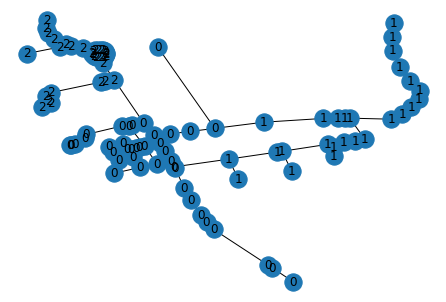

In [23]:
nx.draw(graph, node_coords_dict,labels=labels)

In [24]:
X = []    # collect nodes

for node in graph.nodes:

    X.append([graph.nodes[node]['X'], graph.nodes[node]['Y']])
    
    
X = np.array(X)



# clustering

adj_mat_sparse = nx.to_numpy_matrix(graph, weight='length')

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=adj_mat_sparse).fit(X)






# assign cluster labels

i_label = 0

for node in list(graph.nodes):

    graph.nodes[node]['cluster'] = clustering.labels_[i_label]
    
    i_label += 1
    
labels = nx.get_node_attributes(graph, 'cluster') 

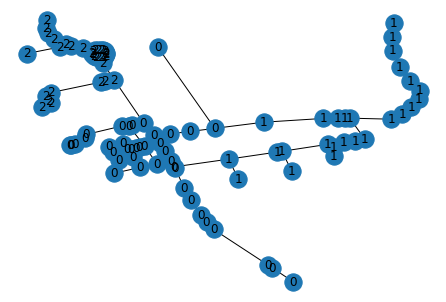

In [25]:
nx.draw(graph, node_coords_dict,labels=labels)